In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import cv2
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          resized_image: RGB image resized from original input image.
          seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map
    
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
    A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

In [3]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = '/Users/cmchang/magic-effect/model/'#tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


### Function: person segmentation

In [4]:
def run_visualization(f):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(f)
    print('running deeplab on image %s...' % f)
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)
    return resized_im, seg_map

In [ ]:
def load_and_run_person_segmentation(f):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(f)
    print('running deeplab on image %s...' % f)
    resized_im, seg_map = MODEL.run(original_im)
    return resized_im, seg_map

### Function: find contour and get stroke path

In [772]:
def find_cntr(image):
    '''input: cv2_img = cv2.imread(img_path)'''
    '''output: mask '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,th2 = cv2.threshold(gray,10,1,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(th2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    # sort contours based on the contour area
    areas = [-cv2.contourArea(contour) for contour in contours]
    
    # remove the contours with small area
    num = np.sum(np.array(areas) < -1000)
    return [contours[top] for top in np.argsort(areas)[:num]]

def get_stroke(person_mask, width=10):
    element = cv2.getStructuringElement(cv2.MORPH_RECT,(width,width))
    dilate = cv2.dilate(person_mask, element)
    result = cv2.absdiff(dilate, person_mask)
    retval, result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)
    result_mask = np.stack((result/255.0,
                               result/255.0,
                               result/255.0), axis=2).astype(np.uint8)
    result_mask = cv2.medianBlur(result_mask, 1)
    return result_mask

### Function: find the location to add patterns

In [1131]:
def rotate_vector(vector, degree):
    """
    @vector: two dimension input like [1, 0], (1,0), or np.array([1, 0])
    @degree: rotation angle
    
    [ cos0 -sin0
      sin0  cos0 ]
    
    return roration vector
    """
    cos = np.cos(np.pi/180 * degree)
    sin = np.sin(np.pi/180 * degree)
    
    return [vector[0] * cos - vector[1] * sin, vector[0] * sin + vector[1] * cos]

def add_line(cntr_points, length, space, angle):
    """
    add patterns between any two consecutive points (a, b)
    
    Arguments
    @points: points of interest
    @length: the length of the line
    @space:  the space between the contour and perpendicular lines
    @angle:  the rotation angle of the vector, b - a
    
    Return
    - np.array(p1): the start point of lines
    - np.array(p2): the end point of lines
    """
    p1 = list()
    p2 = list()
    for i in range(len(cntr_points)-1):
        a = cntr_points[i]
        b = cntr_points[i+1]
        midx, midy = (a+b)/2
        
        vx, vy = b - a
        mag = np.sqrt( vx**2 + vy**2)
        
        vx = vx/mag
        vy = vy/mag
        
        wx, wy = rotate_vector(vector=[vx, vy], degree=angle)
        
        cx = int(midx + space*wx)
        cy = int(midy + space*wy)
        
        dx = int(cx + wx * length)
        dy = int(cy + wy * length)
        
        p1.append([cx, cy])
        p2.append([dx, dy])
    return np.array(p1), np.array(p2)

In [1132]:
colors = np.array([(102,194,165),(252,141,98),(141,160,203),(231,138,195),(166,216,84)], dtype=np.uint8)

## 1. stroke-around effect

In [1133]:
def run_stroke_effect(f, stroke_thickness=10):
    rgb, mask = run_visualization(f)
    rgb = np.array(rgb)
    fore  = np.array(mask == 15, np.uint8) * 255
    
    # find contours on person semantic mask
    k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))
    
    # select at most five contours
    num = min(len(k), 5)
    
    # combine all contours with different colors
    s = np.zeros(rgb.shape, np.uint8)
    for i in range(num):
        canvas = np.zeros(rgb.shape[0:2], np.uint8)
        fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
        s += cv2.medianBlur(get_stroke(fore, width=stroke_thickness)*colors[i], 1)
        
    # combine with original images
    rgb_new = rgb*(1-(s>0)) + s
    return rgb_new

## 2. shine effect

In [1134]:
def run_shine_effect(f, sample_rate, length, space, angle,
                     stroke_thickness=10, line_thickness=3):
    """
    @f: filename
    
    """
    rgb, mask = run_visualization(f)
    rgb = np.array(rgb)
    fore = np.array(mask == 15, np.uint8) * 255

    # find contours on person semantic mask
    k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))

    # select at most five contours
    num = min(len(k), 5)
    colors = np.array([(102,194,165),(252,141,98),(141,160,203),(231,138,195),(166,216,84)], dtype=np.uint8)

    # combine all contours with different colors
    s = np.zeros(rgb.shape, np.uint8)
    for i in range(len(k)):
        l = np.zeros(rgb.shape, np.uint8)
        points = np.mean(k[i], axis=1)
        
        pattern_points = points[::sample_rate]

        new_points1, new_points2 = add_line(cntr_points=pattern_points, length=length, space=space, angle=angle)
        for j in range(len(new_points1)):
            cv2.line(l, tuple(new_points1[j]), tuple(new_points2[j]), color=(1,1,1), thickness=line_thickness, lineType=8)
        canvas = np.zeros(rgb.shape[0:2], np.uint8)
        fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
        l += cv2.medianBlur(get_stroke(fore, width=stroke_thickness), 1)
        s += np.clip(l, a_max=1, a_min=0)*colors[i]

    rgb_new = rgb*(1-(s>0)) + s
    return rgb_new

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1527.jpg...


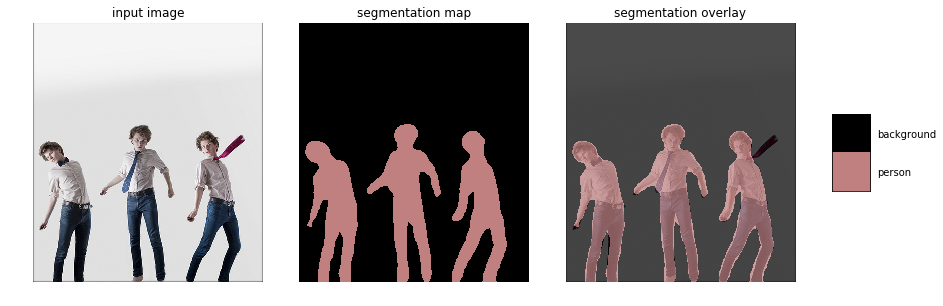

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1527.jpg...


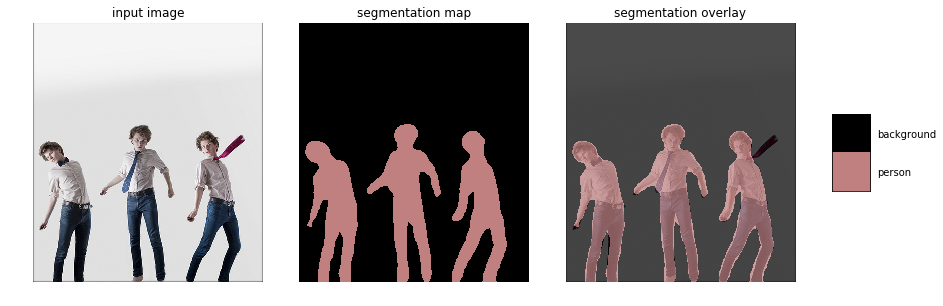

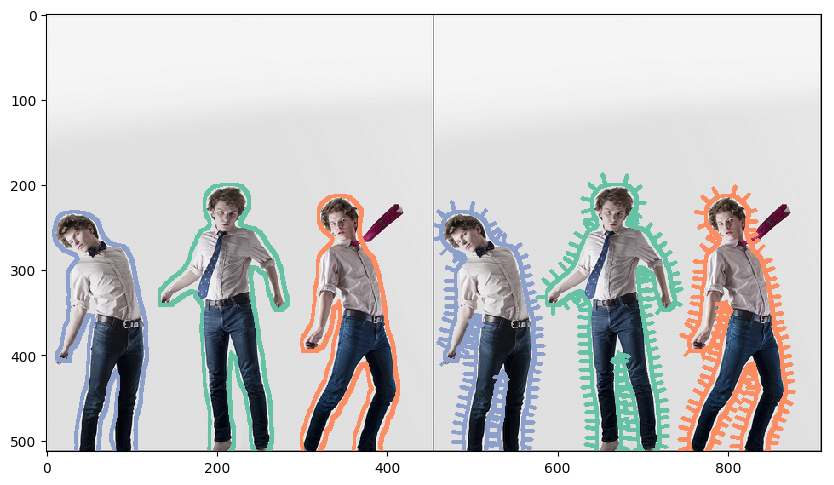

In [1135]:
f = "/Users/cmchang/dataset/person_dog_cat/only_person/image_1527.jpg"
f1 = run_stroke_effect(f)
f2 = run_shine_effect(f, sample_rate=10, length=10, space=5, angle=90)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(np.concatenate((f1,f2), axis=1))
#plt.imsave(arr=newf.astype(np.uint8),fname='/Users/cmchang/magic-effect/stroke-'+os.path.basename(f))

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_64.jpg...


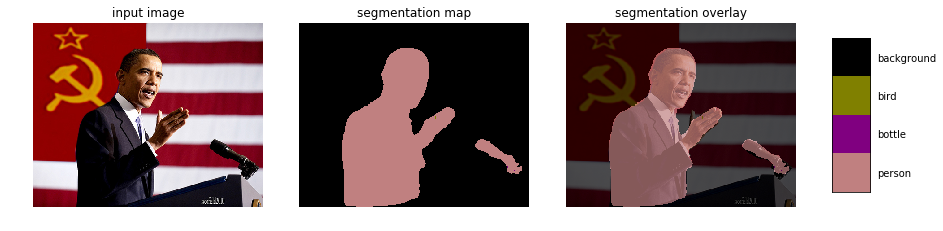

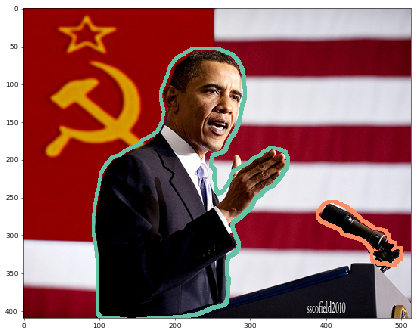

In [1076]:
f = "/Users/cmchang/dataset/person_dog_cat/only_person/image_64.jpg"
newf = run_stroke_effect(f)
plt.figure(figsize=(10,10), dpi=50)
plt.imshow(newf)

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/COCO_COCO_train2014_000000315487.jpg...


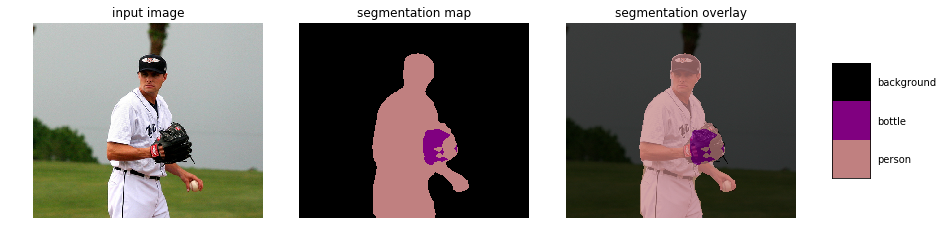

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/COCO_COCO_train2014_000000315487.jpg...


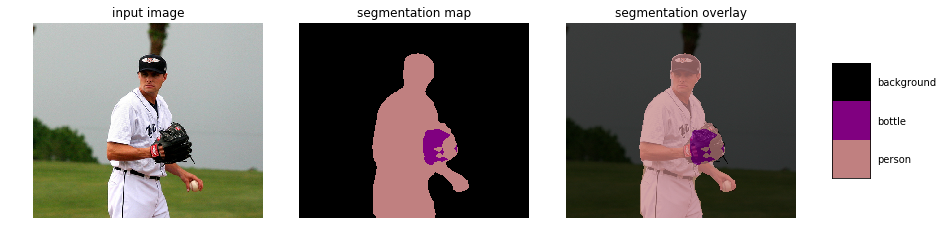

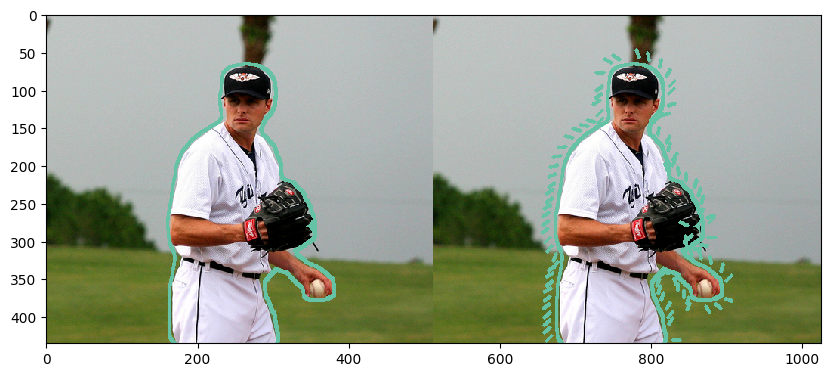

In [1143]:
f = "/Users/cmchang/dataset/person_dog_cat/only_person/COCO_COCO_train2014_000000315487.jpg"
f1 = run_stroke_effect(f)
f2 = run_shine_effect(f, sample_rate=10, length=10, space=15, angle=45)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(np.concatenate((f1,f2), axis=1))
# plt.imsave(arr=newf.astype(np.uint8),fname='/Users/cmchang/magic-effect/stroke-'+os.path.basename(f))

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1425.jpg...


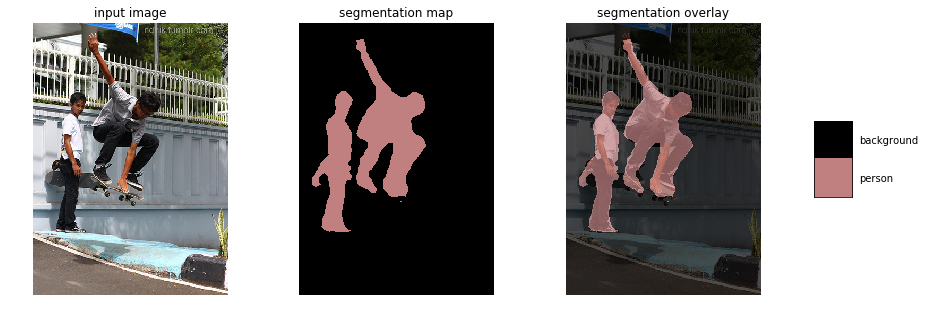

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1425.jpg...


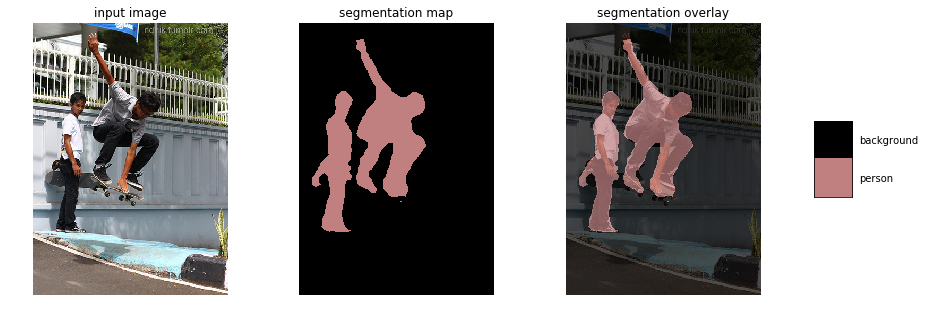

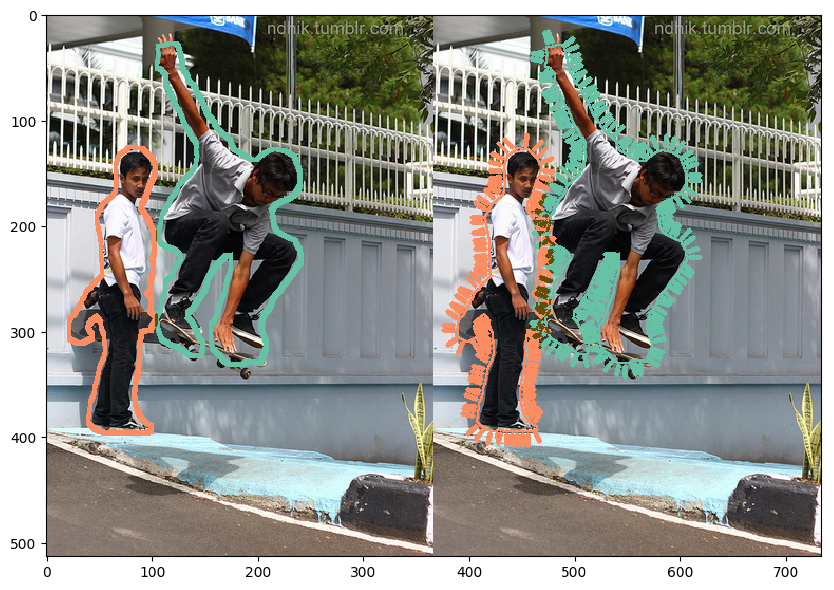

In [871]:
f = "/Users/cmchang/dataset/person_dog_cat/only_person/image_1425.jpg"
f1 = run_stroke_effect(f)
f2 = run_shine_effect(f, sample_rate=5, length=10, space=5, angle=90, line_thickness=3, stroke_thickness=5)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(np.concatenate((f1,f2), axis=1))

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1946.jpg...


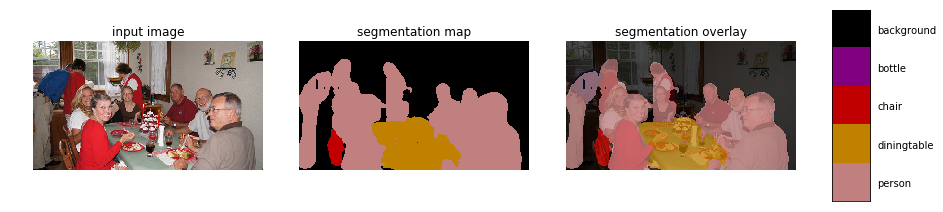

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1946.jpg...


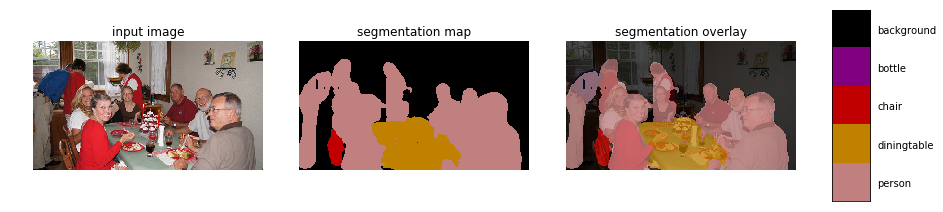

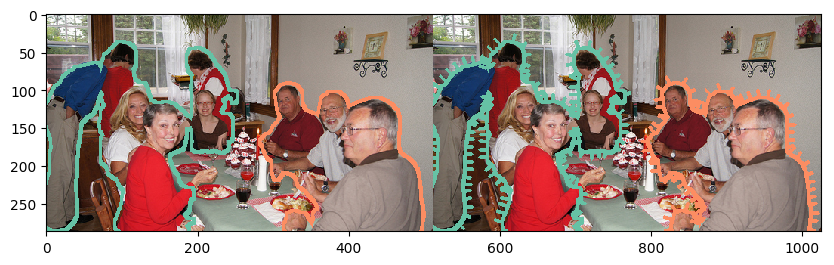

In [873]:
f = "/Users/cmchang/dataset/person_dog_cat/only_person/image_1946.jpg"
f1 = run_stroke_effect(f)
f2 = run_shine_effect(f, sample_rate=10, length=8, space=5, angle=90)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(np.concatenate((f1,f2), axis=1))
# plt.imsave(arr=newf.astype(np.uint8),fname='/Users/cmchang/magic-effect/stroke-'+os.path.basename(f))

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/image_1527.jpg...


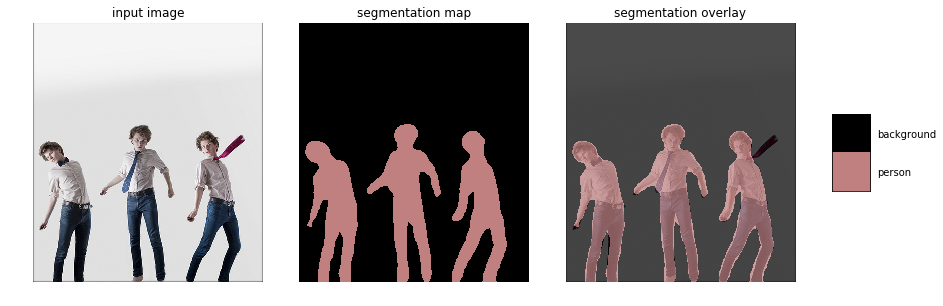

In [1013]:
rgb, mask = run_visualization("/Users/cmchang/dataset/person_dog_cat/only_person/image_1527.jpg") #image_1425.jpg")
                         #image_64.jpg")
                         #COCO_COCO_train2014_000000315487.jpg")
    #"/Users/cmchang/dataset/flickr/smile/39328076960_d33f132c3a_z.jpg")


In [22]:
rgb = np.array(rgb)
fore  = np.array(mask == 15, np.uint8) * 255

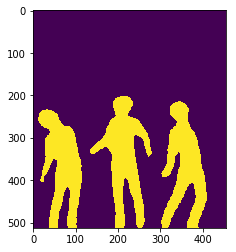

In [23]:
plt.imshow(fore)

In [24]:
k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))
num = min(len(k), 5)
colors = [(102,194,165),(252,141,98),(141,160,203),(231,138,195),(166,216,84)]
s = np.zeros(rgb.shape, np.uint8)
for i in range(num):
    canvas = np.zeros(rgb.shape[0:2], np.uint8)
    fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
    s += get_stroke(fore, color=colors[i], width=10)

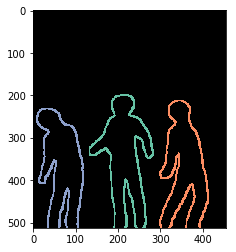

In [25]:
plt.imshow(s)

In [26]:
rgb_new = rgb*(1-(s>0)) + s

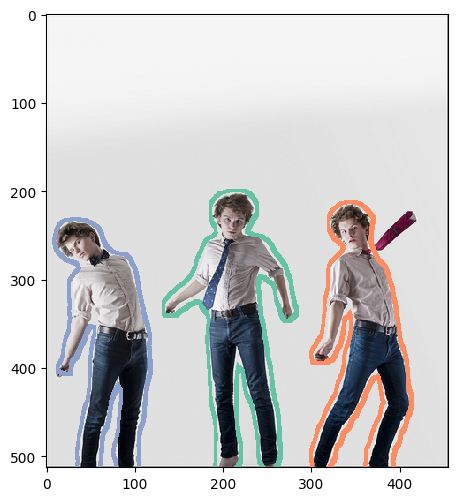

In [27]:
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(rgb_new)

In [1148]:
sample_rate=50
length=10
space=30
angle=90
line_thickness=3
stroke_thickness=10

In [1178]:
icon = np.array(Image.open('flower-icon2.png').resize((50,50)))[:,:]

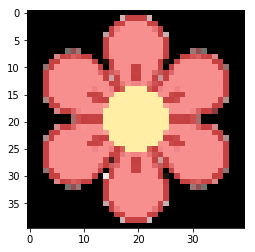

In [1180]:
icon = cv2.cvtColor(cv2.imread('flower-icon2.png'), cv2.COLOR_BGR2RGB)
icon[np.mean(icon, axis=2)>= 255] = 0
icon = cv2.resize(icon, (40,40))
plt.imshow(icon)

running deeplab on image /Users/cmchang/dataset/person_dog_cat/only_person/COCO_COCO_train2014_000000315487.jpg...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


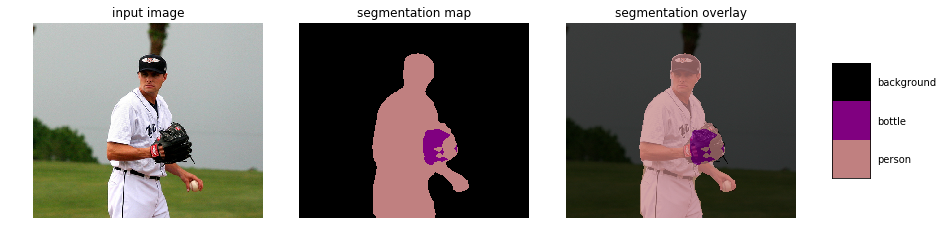

In [1181]:
icon_radius_x, icon_radius_y = icon.shape[0]//2, icon.shape[1]//2

rgb, mask = run_visualization(f)
rgb = np.array(rgb)
fore = np.array(mask == 15, np.uint8) * 255

# find contours on person semantic mask
k = find_cntr(np.stack((fore, fore, fore),axis=2).astype(np.uint8))

# select at most five contours
num = min(len(k), 5)
colors = np.array([(102,194,165),(252,141,98),(141,160,203),(231,138,195),(166,216,84)], dtype=np.uint8)

# combine all contours with different colors
s = np.zeros(rgb.shape, np.uint8)
for i in range(len(k)):
    l = np.zeros(rgb.shape, np.uint8)
    points = np.mean(k[i], axis=1)

    pattern_points = points[::sample_rate]
    new_points1, new_points2 = add_line(cntr_points=pattern_points, length=length, space=space, angle=angle)
    
    new_points2 = new_points2[[True]+[True if np.sum((p[0] > 1.4*icon_radius_x) or (p[1] > 1.4*icon_radius_y))>0 else False for p in np.abs(np.diff(new_points2, axis=0))]]
    
    for j in range(len(new_points2)):
#         cv2.line(l, tuple(new_points1[j]), tuple(new_points2[j]), color=(1,1,1), thickness=line_thickness, lineType=8)
        if (new_points2[j][1]+icon_radius_y < l.shape[0] and new_points2[j][0] + icon_radius_x < l.shape[1]) and (new_points2[j][1]-icon_radius_y > 0 and new_points2[j][0] - icon_radius_x >0):
            l[new_points2[j][1]-icon_radius_y:new_points2[j][1]+icon_radius_y, 
              new_points2[j][0]-icon_radius_x:new_points2[j][0]+icon_radius_x,:] = icon
    canvas = np.zeros(rgb.shape[0:2], np.uint8)
    fore = cv2.drawContours(canvas, k, i, (255,255,255),-1)
    l = l + cv2.medianBlur(get_stroke(fore, width=stroke_thickness), 1) #\* colors[i]
    s += l #np.clip(l, a_max=1, a_min=0)*colors[i]

rgb_new = rgb*(1-(s>0)) + s

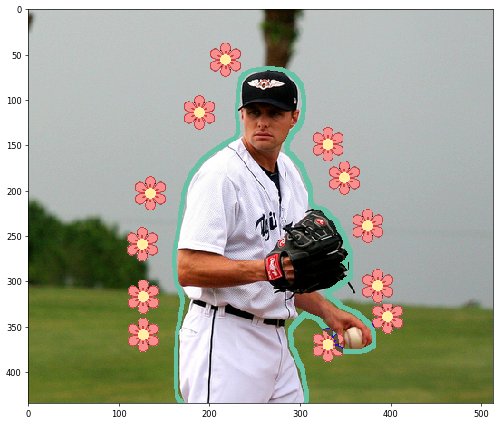

In [1182]:
plt.figure(figsize=(10,10), dpi=60)
plt.imshow(rgb_new)

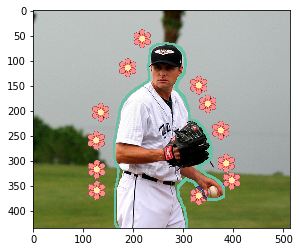

In [1183]:
plt.imshow(rgb_new)

### 3. Pattern-around effect 

### 4. Stand-out effect 